# White Giant Cooling Model - Vertical Channels

In [1]:
#Import required modules
import bamboo as bam
import bamboo.cooling as cool
import bamboo.materials

import numpy as np
import matplotlib.pyplot as plt
import pypropep as ppp
import bamboo.plot
import thermo

### *Engine setup*

In [2]:
'''Chamber conditions'''
pc = 15e5                   #Chamber pressure (Pa)
mdot = 5.4489               #Mass flow rate (kg/s)
p_amb = 1.01325e5           #Ambient pressure (Pa). 1.01325e5 is sea level atmospheric.
OF_ratio = 3.5              #Oxidiser/fuel mass ratio
water_mass_fraction = 0.40  #Fraction of the fuel that is water, by mass

'''Get combustion properties from pypropep'''
ppp.init()
e = ppp.Equilibrium()
ipa = ppp.PROPELLANTS['ISOPROPYL ALCOHOL']
water = ppp.PROPELLANTS['WATER']
n2o = ppp.PROPELLANTS['NITROUS OXIDE']

#Add propellants by mass fractions (note the mass fractions can add up to more than 1)
e.add_propellants_by_mass([(ipa, 1-water_mass_fraction), (water, water_mass_fraction), (n2o, OF_ratio)])

#Adiabatic combustion using chamber pressure                      
e.set_state(P = pc/1e5, type='HP')                      

gamma = e.properties.Isex   #pyrpopep uses 'Isex' for the ratio of specific heats
cp = 1000*e.properties.Cp   #Cp is given in kJ/kg/K, we want J/kg/K
Tc = e.properties.T

'''Set up the engine object'''
perfect_gas = bam.PerfectGas(gamma = gamma, cp = cp)    #Gas for frozen flow
chamber_conditions = bam.ChamberConditions(pc, Tc, mdot)
nozzle = bam.Nozzle.from_engine_components(perfect_gas, chamber_conditions, p_amb, type = "rao")
engine = bam.Engine(perfect_gas, chamber_conditions, nozzle)

print(f"\nNozzle throat area = {nozzle.At} m^2, nozzle exit area = {nozzle.Ae} m^2")

'''Check the thrust and specific impulse'''
print("")
print(f"Chamber Temperature: {Tc} K")
print(f"Gamma = {gamma}")
print(f"cp = {cp} J/kg/K")
print("")
print(f"Sea level thrust = {engine.thrust(1e5)/1000} kN      (using perfect gas relations)")
print(f"Sea level Isp = {engine.isp(1e5)} s         (using perfect gas relations)")



Loaded 1921 thermo species
Loaded 1031 propellants
bamboo.main.rao_theta_n(): Area ratio is outside the range of the Rao inflection angle data, returning 15 deg instead.
bamboo.main.rao_theta_e(): Area ratio is outside the range of the Rao exit angle data, returning 14.999 deg instead.

Nozzle throat area = 0.006712812133545899 m^2, nozzle exit area = 0.021131183305612325 m^2

Chamber Temperature: 2895.328510803194 K
Gamma = 1.1430282235267117
cp = 3827.3842050453954 J/kg/K

Sea level thrust = 13.752350411700128 kN      (using perfect gas relations)
Sea level Isp = 257.36377399776666 s         (using perfect gas relations)


### *Cooling simulation*

In [3]:
'''Transport properties'''
#We'll set up a very crude exhaust gas model using thermo.
thermo_gas = thermo.mixture.Mixture(['N2', 'H2O', 'CO2'], zs = [1, 0.2, 0.2])  

#Setup the exhaust gas transport properties
def Pr_gas(T, p):
    thermo_gas.calculate(T, p)
    return thermo_gas.Prg

def mu_gas(T, p):
    thermo_gas.calculate(T, p)
    return thermo_gas.mug

def k_gas(T, p):
    thermo_gas.calculate(T, p)
    return thermo_gas.kg

gas_transport = bam.cooling.TransportProperties(type = "functions",
                                                Pr = Pr_gas,
                                                mu = mu_gas,
                                                k = k_gas)

#Set up the coolant transport properties
thermo_coolant = thermo.chemical.Chemical('isopropanol')

def Pr_coolant(T, p):
    thermo_coolant.calculate(T, p)
    return thermo_coolant.Prl

def mu_coolant(T, p):
    thermo_coolant.calculate(T, p)
    return thermo_coolant.mul

def k_coolant(T, p):
    thermo_coolant.calculate(T, p)
    return thermo_coolant.kl

def cp_coolant(T, p):
    #I'm fixing temperature at 320K, because I don't entirely trust thermo's value's for cp
    thermo_coolant.calculate(T = 320, P = p)   
    return thermo_coolant.Cpl

def rho_coolant(T, p):
    thermo_coolant.calculate(T, p)
    return thermo_coolant.rhol

coolant_transport = bam.cooling.TransportProperties(type = "functions",
                                                    Pr = Pr_coolant,
                                                    mu = mu_coolant,
                                                    k = k_coolant,
                                                    cp = cp_coolant,
                                                    rho = rho_coolant)

#Add the gas transport properties to the engine
engine.add_exhaust_transport(gas_transport)

#Coolant transport properties will get used later when creating adding the CoolingJacket to the engine

Wall material properties:
bamboo.cooling.Material Object
        Young's modulus = 140.0 GPa 
        0.2% Yield Stress = 600.0 MPa 
        Poisson's ratio = 0.355
        alpha = 1.75e-05 strain/K
        Thermal conductivity = 211 W/m/K
        (may also have a specific heat capacity (self.c) and density (self.rho))

 Graphite insert properties:
bamboo.cooling.Material Object
        Young's modulus = nan GPa 
        0.2% Yield Stress = nan MPa 
        Poisson's ratio = nan
        alpha = nan strain/K
        Thermal conductivity = 63.81001 W/m/K
        (may also have a specific heat capacity (self.c) and density (self.rho))



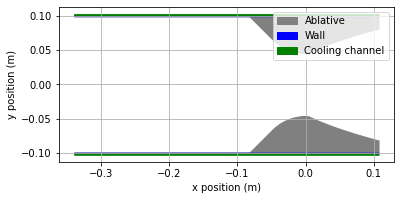

In [4]:
'''Chamber and wall geometry'''
Ac = np.pi*0.1**2                      #Chamber cross-sectional area (m^2)
inner_wall_thickness = 1e-3                  #Thickness of the metal engine liner (m)
L_star = 1.2                           #L_star = Volume_c/Area_t
chamber_length = L_star*nozzle.At/Ac   #Length of the combustion chamber
engine.add_geometry(chamber_length, Ac, inner_wall_thickness)

'''Coolant jacket'''
mdot_coolant = mdot/(OF_ratio + 1)               #Coolant mass flow rate
inlet_T = 298.15                                 #Coolant inlet temperature
inlet_p0 = 40e5                                  #Tank / inlet coolant stagnation pressure (Pa)
wall_material = bam.materials.CopperC700         #Copper inner wall

#Add the cooling jacket
engine.add_cooling_jacket(wall_material, 
                          inlet_T, 
                          inlet_p0, 
                          coolant_transport, 
                          mdot_coolant, 
                          configuration = "vertical", 
                          channel_height = 2e-3,
                          blockage_ratio = 0.4,
                          number_of_ribs = 20)


'''Graphite insert'''
ablative_material = bam.materials.Graphite
engine.add_ablative(ablative_material)

#Print the wall and ablative material properties
print("Wall material properties:")
print(wall_material)

print("\n Graphite insert properties:")
print(ablative_material)
print("")

#Plot the geometry
engine.plot_geometry()
plt.show()

In [5]:
#Run simulation
heating_data = engine.steady_heating_analysis(to_json = False, h_gas_model = 'bartz-sigma', h_coolant_model = 'sieder-tate')

D:\anaconda3\lib\site-packages\thermo\viscosity.py:826: RuntimeWarning: invalid value encountered in double_scalars
  D = 0.3257/((1.0039-Tr**2.573)**0.2906) - 0.2086


TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'

In [ ]:
#Show plots
bam.plot.plot_temperatures(heating_data, show_gas = True, show_ablative = True)
bam.plot.plot_temperatures(heating_data, show_gas = False, show_ablative = False)

plt.show()

Plot everything else:

In [ ]:
bam.plot.plot_jacket_pressure(heating_data)
plt.title("Coolant Static Pressure")

bam.plot.plot_h(heating_data)
plt.title("Convective Heat Transfer Coefficients")

bam.plot.plot_qdot(heating_data)
plt.title("Heat Transfer Rates (per axial unit length)")

bam.plot.plot_resistances(heating_data)
plt.title("Thermal Resistances (per axial unit length)")

bam.plot.plot_exhaust_properties(heating_data)
plt.title("")

bam.plot.plot_coolant_properties(heating_data)